### End-to-End Machine Learning Project
1. Frame the problem and look at the big picture (Introduction and motivation)
2. Get the data (Methodology)
3. Explore the data and to get insights (Methodology)
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms (Methodology)
5. Explore many different models and short-list the best ones (Methodology)
6. Fine-tune your model and combine them into a great solution (Methodology)
7. Present your solution (Results and Conclusion)

### 1. Frame the problem and look at the big picture
Tropical cyclones are axisymmetric, cyclonic storms that, based on observations and theoretical studies, have been favored to form in warm, humid, and convective environments within Earth's tropics. Outside of Earth, Saturn's biggest moon, Titan, is the only known celestial body to have a climate that is similar to Earth's tropical atmosphere due to it's slower rotation rate, resulting in a nearly global tropical environment. With the addition of high methane vapor in the mid-troposphere and large seas at Titan's poles that experiences convective storms during the summer months, it would be possible for Titan to be a "tropical cyclone" playground. However, no tropical cyclones have been observed on Titan. Thus, it leads to the question: What environmental parameters are causing a decline in tropical cyclogenesis between Earth-like and Titan-like regimes? To answer this question, we need to measure the favorability of tropical cyclones between the two regimes. One such metric is called the maximum potential intensity (MPI), which measures the highest wind speed that a tropical cyclone can attain, given current environmental conditions. For Earth, MPI are mostly driven by a combination of warm sea-surface temperatures and high atmospheric humidity. However, for Titan, it is unclear what variables within MPI would be necessary for tropical cyclogenesis to occur. Thus, our main goal is to use machine learning regression techniques and feature importance to figure out which variables is playing a major role in MPI on Titan.

### 2. Get Data

In [3]:
#importing modules
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
from metpy.units import units
import metpy.calc as mpcalc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import pandas as pd
import pickle

In [12]:
#Get the data, organize variables
main_dataset = pickle.load(open("main_dataset.p","rb"))
test_mpi = main_dataset[0]
test_asd = main_dataset[1]
test_dh = main_dataset[2]
test_sst = main_dataset[3]
test_ssh = main_dataset[4]
test_sh = main_dataset[5]
test_ks = main_dataset[6]
test_ka = main_dataset[7]
test_t1 = main_dataset[8]
lat = main_dataset[9]
lon = main_dataset[10]
time = main_dataset[11]

Text(0, 0.5, 'Latitude')

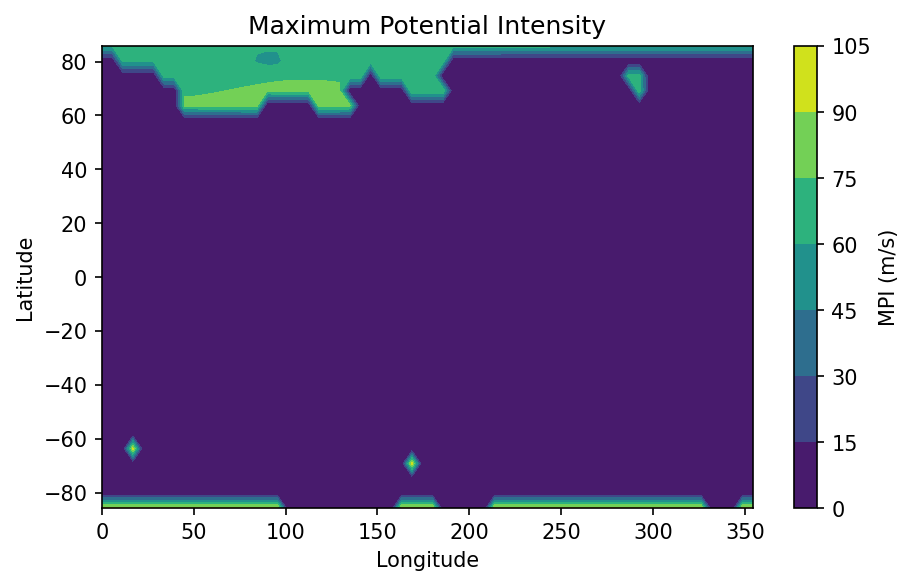

In [13]:
#Visualize the data
fig = plt.figure(figsize=(7,4),dpi=150)
plt.contourf(lon,lat,test_mpi[0])
plt.title("Maximum Potential Intensity")
cbar = plt.colorbar()
cbar.set_label("MPI (m/s)")
plt.xlabel("Longitude")
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

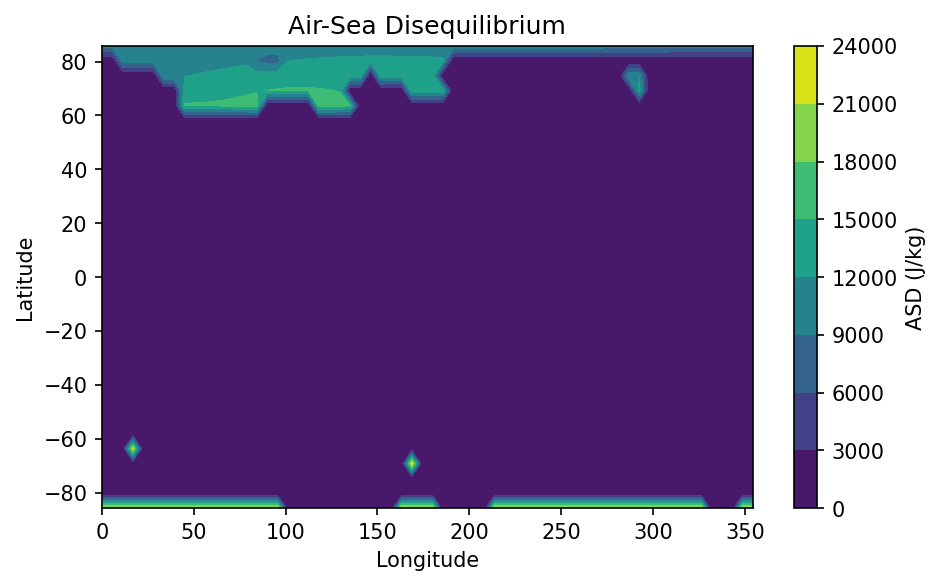

In [14]:
#look at the individual components of MPI
#Air-Sea Disequilibrium
fig = plt.figure(figsize=(7,4),dpi=150)
plt.contourf(lon,lat,test_asd[0])
cbar = plt.colorbar()
cbar.set_label("ASD (J/kg)")
plt.title("Air-Sea Disequilibrium")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Latitude')

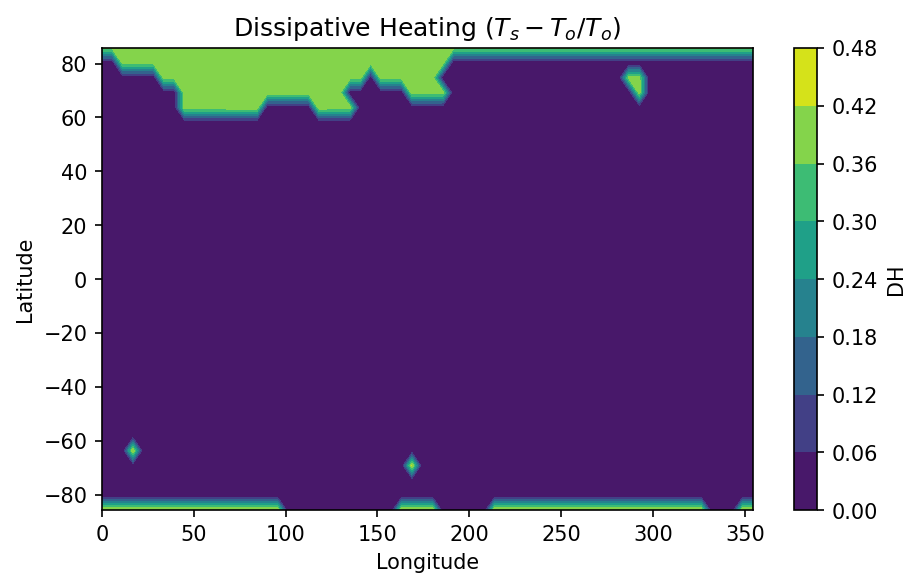

In [15]:
#Dissipative Heating
fig = plt.figure(figsize=(7,4),dpi=150)
plt.contourf(lon,lat,test_dh[0])
cbar = plt.colorbar()
cbar.set_label("DH")
plt.title("Dissipative Heating ($T_s-T_o/T_o$)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [16]:
#Look at the shape
print('shape of test_mpi:', len(test_mpi))
print()
print('shape of test_asd:', len(test_asd))
print()
print('shape of test_dh:', len(test_dh))

shape of test_mpi: 50

shape of test_asd: 50

shape of test_dh: 50


### 4. Clean up the data to use for ML models

In [17]:
#Create a function to clean up the data and make it ready for ML model selection
mpi_dfs = []
dh_dfs = []
asd_dfs = []
sh_dfs = []
sst_dfs = []
ssh_dfs = []
ks_dfs = []
ka_dfs = []
t1_dfs = []
for x in range(50):
    
    #Reshape the shape
    mpi_reshape = np.reshape(test_mpi[x],2048)
    dh_reshape = np.reshape(test_dh[x],2048)
    asd_reshape = np.reshape(test_asd[x],2048)
    ssh_reshape = np.reshape(test_ssh[x],2048)
    sst_reshape = np.reshape(test_sst[x],2048)
    sh_reshape = np.reshape(test_sh[x],2048)
    ks_reshape = np.reshape(test_ks[x],2048)
    ka_reshape = np.reshape(test_ka[x],2048)
    t1_reshape = np.reshape(test_t1[x],2048)
    
    #Append
    mpi_dfs.append(mpi_reshape)
    dh_dfs.append(dh_reshape)
    asd_dfs.append(asd_reshape)
    sh_dfs.append(sh_reshape)
    ssh_dfs.append(ssh_reshape)
    sst_dfs.append(sst_reshape)
    ks_dfs.append(ks_reshape)
    ka_dfs.append(ka_reshape)
    t1_dfs.append(t1_reshape)

In [18]:
#Reorganize the lat and lon
lat_reshape = []
lon_reshape = []
for x in range(len(lat)):
    for y in range(len(lon)):
        lat_reshape.append(x)
        lon_reshape.append(y)

In [19]:
#Create a list of dataframes
main_data = []
for x in range(50):
    df = pd.DataFrame(data={'MPI': mpi_dfs[x], 'Latitude': lat_reshape, 'Longitude':lon_reshape,'air_sea_diseq': asd_dfs[x], 'diss_heat': dh_dfs[x],'SSH_sea_surface':ssh_dfs[x],'SH_boundary_layer':sh_dfs[x],'SST':sst_dfs[x],'sat_specific_enthalpy(sea_surface)':ks_dfs[x],'specific_enthalpy(boundary_layer)':ka_dfs[x],'bl_temp':t1_dfs[x]})
    main_data.append(df)

In [20]:
#Visualize the dataframe
main_data[30]

,MPI,Latitude,Longitude,air_sea_diseq,diss_heat,SSH_sea_surface,SH_boundary_layer,SST,sat_specific_enthalpy(sea_surface),specific_enthalpy(boundary_layer),bl_temp
0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.416573
1,0.000000,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.415649
2,0.000000,0,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.414284
3,0.000000,0,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.412521
4,0.000000,0,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.410408
...,...,...,...,...,...,...,...,...,...,...,...
2043,69.361597,31,59,12379.886555,0.388617,0.053624,0.031560,91.648705,128289.636068,115909.749513,91.561417
2044,69.596067,31,60,12458.015397,0.388795,0.053703,0.031489,91.660461,128346.394152,115888.378755,91.578018
2045,69.800313,31,61,12525.722030,0.388966,0.053779,0.031436,91.671776,128401.052649,115875.330620,91.593437
2046,70.039435,31,62,12604.483090,0.389189,0.053878,0.031394,91.686455,128471.982172,115867.499083,91.607552


**Description of the individual columns within the dataframe**
- `MPI`: Maximum Potential Intensity - the maximum wind speed that a tropical cyclone can attain, given the current environmental conditions (in m/s). 
- `Latitude`: Latitude (Y coordinates)
- `Longitude`: Longitude (X coordinates)
- `air_sea_diseq`: Air-sea disequilbrium term $(ks - ka)$, where $k_s$ is the specific enthalpy at the surface (assuming saturated conditions) and $k_a$ is the specific enthalpy at the top of the boundary layer (assuming unsaturated conditions, in J/kg).
- `diss_heat`: Dissipative heating term $\frac{(T_s - T_o)}{T_o}$ - accounts for the effect of dissipative heating (i.e., heat energy that comes from frictional dissipation) and TC heat engine efficiency (unitless).
- `SSH_sea_surface`: saturation specific humidity (sea-surface) - the specific humidity (i.e., the amount of water vapor in a volume of air) at the sea surface (assuming saturated conditions, in kg/kg)
- `SH_boundary_layer`: specific humidity at the top of the boundary layer (in kg/kg)
- `SST` Sea-surface temperature (in Kelvin)
- `sat_specific_enthalpy(sea_surface)`- the specific enthalpy (i.e., the amount of heat energy) at the sea surface (assuming saturated conditions, J/kg)
- `specific-enthalpy(boundary_layer)` - the specific enthalpy at the top of the boundary layer (J/kg)
- `bl_temp` - temperature at the top of the boundary layer (in Kelvin)

### Looking for corrleations between MPI and the individual variables in the dataframe

In [21]:
corr_matrix = main_data[30].corr()
corr_matrix['MPI'].sort_values(ascending=False)

MPI                                   1.000000
diss_heat                             0.994652
air_sea_diseq                         0.994083
SH_boundary_layer                     0.734891
specific_enthalpy(boundary_layer)     0.714363
SST                                   0.710435
sat_specific_enthalpy(sea_surface)    0.699748
SSH_sea_surface                       0.665163
Latitude                              0.282060
Longitude                             0.069091
bl_temp                              -0.503327
Name: MPI, dtype: float64

- Dissipative heating and air-sea disequiibrium appears to have a strong correlation to MPI. What's more interesting is the dissipative heating term has a slightly stronger correlation to MPI than the air-sea disequilibrium. 

array([[<Axes: xlabel='MPI', ylabel='MPI'>,
        <Axes: xlabel='air_sea_diseq', ylabel='MPI'>,
        <Axes: xlabel='diss_heat', ylabel='MPI'>,
        <Axes: xlabel='SH_boundary_layer', ylabel='MPI'>,
        <Axes: xlabel='specific_enthalpy(boundary_layer)', ylabel='MPI'>,
        <Axes: xlabel='SST', ylabel='MPI'>,
        <Axes: xlabel='sat_specific_enthalpy(sea_surface)', ylabel='MPI'>],
       [<Axes: xlabel='MPI', ylabel='air_sea_diseq'>,
        <Axes: xlabel='air_sea_diseq', ylabel='air_sea_diseq'>,
        <Axes: xlabel='diss_heat', ylabel='air_sea_diseq'>,
        <Axes: xlabel='SH_boundary_layer', ylabel='air_sea_diseq'>,
        <Axes: xlabel='specific_enthalpy(boundary_layer)', ylabel='air_sea_diseq'>,
        <Axes: xlabel='SST', ylabel='air_sea_diseq'>,
        <Axes: xlabel='sat_specific_enthalpy(sea_surface)', ylabel='air_sea_diseq'>],
       [<Axes: xlabel='MPI', ylabel='diss_heat'>,
        <Axes: xlabel='air_sea_diseq', ylabel='diss_heat'>,
        <Axes: xlabe

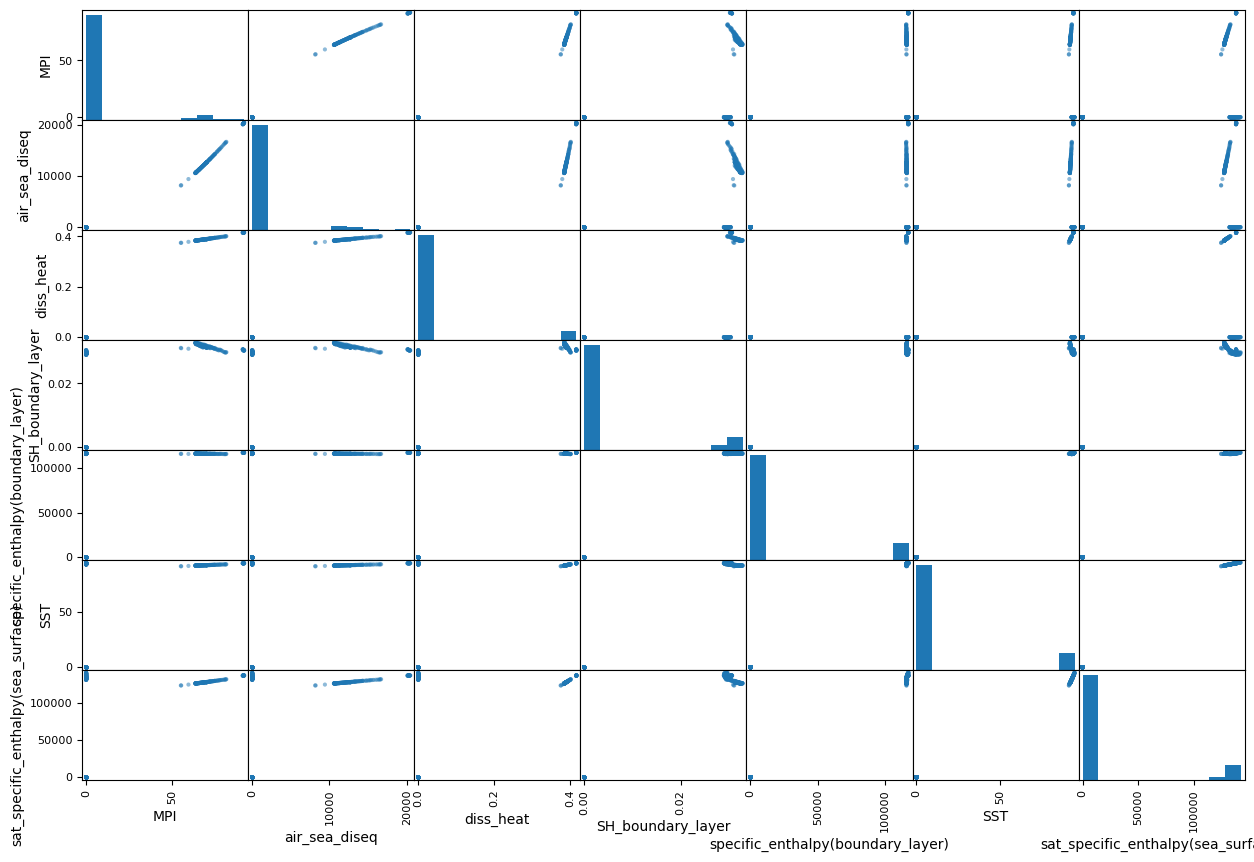

In [22]:
#Let's look at the scatter matrix
from pandas.plotting import scatter_matrix
attributes = ["MPI","air_sea_diseq", "diss_heat","SH_boundary_layer","specific_enthalpy(boundary_layer)","SST","sat_specific_enthalpy(sea_surface)"]
scatter_matrix(main_data[30][attributes],figsize=(15,10))

C:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='air_sea_diseq', ylabel='MPI'>

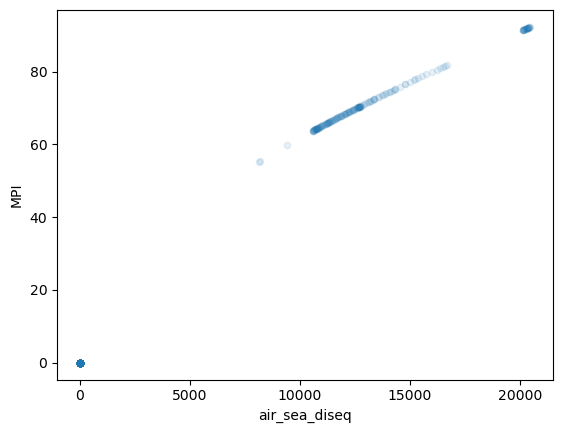

In [23]:
#look at the relationship between air-sea disequilibrium and MPI
main_data[30].plot(kind="scatter", x="air_sea_diseq", y="MPI",
alpha=0.1)

<Axes: xlabel='diss_heat', ylabel='MPI'>

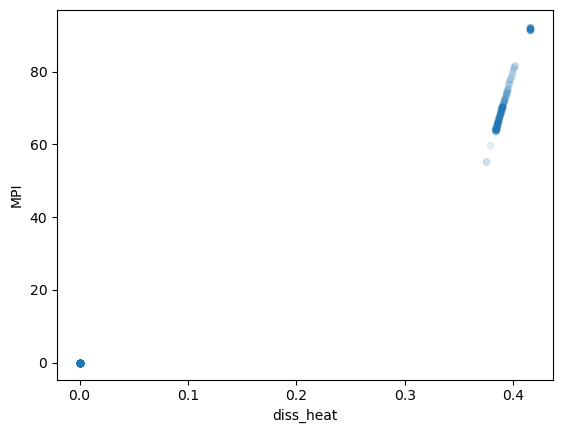

In [24]:
#look at the relationship between dissipative heating and MPI
main_data[30].plot(kind="scatter", x="diss_heat", y="MPI",
alpha=0.1)

### 5. Explore the different models to use and make a short-list

### 1. Linear Regression (ridge regularization)

In [25]:
#Handle the data shape
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

#Splitting the data into train and test sets
X_data_days = []
Y_data_days = []
for x in range(50):
    X_data = main_data[x].drop(['MPI'],axis=1).values
    Y_data = main_data[x]['MPI'].values
    Y_data = Y_data.reshape(-1,1)
    X_data_days.append(X_data)
    Y_data_days.append(Y_data)

#Check the shape, should be (50,2048) for all
print('shape of X_data_days:', np.shape(X_data_days))
print()
print('shape of Y_data_days:', np.shape(Y_data_days))

#Convert to arrays
X_data_days = np.asarray(X_data_days)
Y_data_days = np.asarray(Y_data_days)

#Reshape the arrays
#Have to combine the time and sample lengths to adhere to the 2-D array requirement
X_data_days = X_data_days.reshape(-1,X_data_days.shape[-1])
Y_data_days = Y_data_days.reshape(-1,Y_data_days.shape[-1])

#Checking the reshaped X and Y
print()
print('shape of reshaped X_data_days:', np.shape(X_data_days))
print()
print('shape of reshaped Y_data_days:', np.shape(Y_data_days))

shape of X_data_days: (50, 2048, 10)

shape of Y_data_days: (50, 2048, 1)

shape of reshaped X_data_days: (102400, 10)

shape of reshaped Y_data_days: (102400, 1)


In [26]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_data_days, Y_data_days, test_size=0.2, shuffle=False)

print()
print('shape of xtrain:', np.shape(x_train))
print()
print('shape of ytrain:', np.shape(y_train))
print()
print('shape of xtest:', np.shape(x_test))
print()
print('shape of ytest:', np.shape(y_test))
print()

#SCALE THE DATA - each of the features are at different ranges (ASD - 0 - 10000 J/kg, DH = 0 - 1)
#Scale the xdata
Xscaler = StandardScaler()
Xscaler.fit(x_train)
X_train_scaled = Xscaler.transform(x_train)

#Scale the ydata
Yscaler = StandardScaler()
Yscaler.fit(y_train)
Y_train_scaled = Yscaler.transform(y_train)

#FIT THE MODEL
# Initialize and train a linear regression model with ridge regularization, using make_pipeline
linear_reg = Ridge(alpha=1.0)

#fit the model
linear_reg.fit(X_train_scaled,Y_train_scaled)

#EVAULATE THE MODEL
#scale the testing data using the scaler that we already fitted with the training data
X_test_scaled = Xscaler.transform(x_test)

#get the model prediction on the test data
Y_pred_scaled = linear_reg.predict(X_test_scaled)

y_pred = Yscaler.inverse_transform(Y_pred_scaled.reshape(-1, 1))

# Evaluate the model
from sklearn.metrics import mean_absolute_error
print("RMSE for linear regression:", np.sqrt(np.mean((y_test-y_pred)**2)))


shape of xtrain: (81920, 10)

shape of ytrain: (81920, 1)

shape of xtest: (20480, 10)

shape of ytest: (20480, 1)

RMSE for linear regression: 0.10689449439856824


In [27]:
#Very low RMSE, despite negative values in the southern hemisphere
#Evaulate using cross-validation
from sklearn.model_selection import cross_val_score

In [28]:
scores = cross_val_score(linear_reg, X_train_scaled, Y_train_scaled, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [29]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rmse_scores)

Scores: [0.00538689 0.00536689 0.00567769 0.00604391 0.00535189 0.00485785
 0.00480568 0.00448508 0.00403607 0.00377882]
Mean: 0.004979076647704384
Standard deviation: 0.0006852942439242813


In [30]:
#Reshape the arrays for the y_test and y_pred
ypred = np.reshape(y_pred,(10,32,64))
ytest = np.reshape(y_test,(10,32,64))

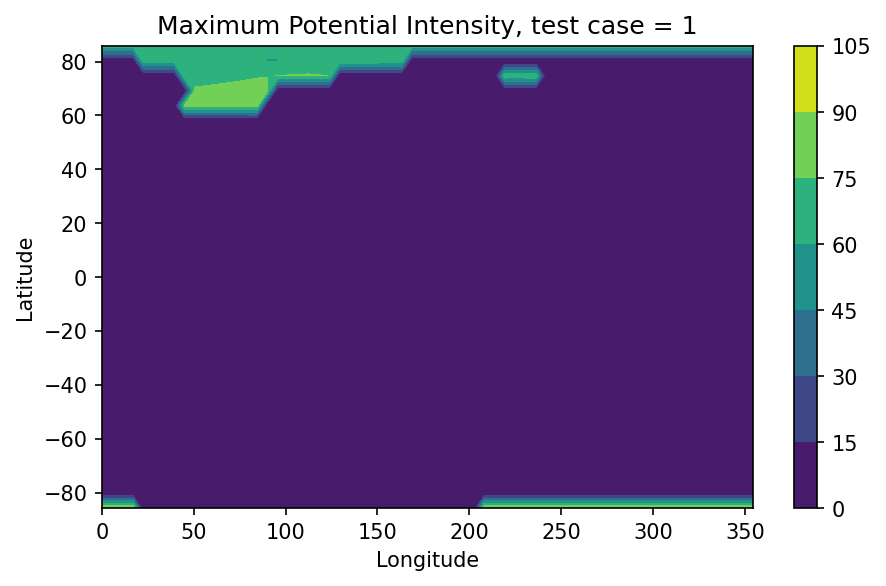

In [31]:
#Visualize the results, test_case = 1
fig = plt.figure(figsize=(7,4),dpi=150)
plt.title("Maximum Potential Intensity, test case = 1")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.contourf(lon,lat,ytest[0])
plt.colorbar()

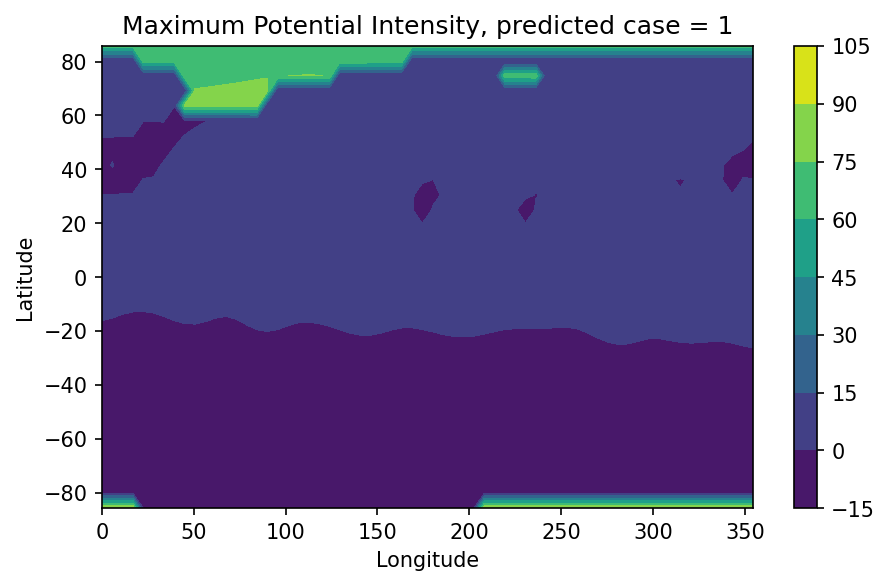

In [32]:
#Visualize the results, predicted_case = 1
fig = plt.figure(figsize=(7,4),dpi=150)
plt.title("Maximum Potential Intensity, predicted case = 1")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.contourf(lon,lat,ypred[0])
plt.colorbar()

In [33]:
main_data[30].corr()

,MPI,Latitude,Longitude,air_sea_diseq,diss_heat,SSH_sea_surface,SH_boundary_layer,SST,sat_specific_enthalpy(sea_surface),specific_enthalpy(boundary_layer),bl_temp
MPI,1.000000,2.820605e-01,6.909064e-02,0.994083,0.994652,0.665163,0.734891,0.710435,0.699748,0.714363,-0.503327
Latitude,0.282060,1.000000e+00,-3.913648e-16,0.243901,0.314164,0.378043,0.411274,0.403853,0.397758,0.405052,-0.613614
Longitude,0.069091,-3.913648e-16,1.000000e+00,0.065664,0.070822,0.108835,0.110260,0.110439,0.110145,0.110280,0.001262
air_sea_diseq,0.994083,2.439014e-01,6.566400e-02,1.000000,0.977592,0.659058,0.718269,0.696746,0.687954,0.700204,-0.471860
diss_heat,0.994652,3.141638e-01,7.082234e-02,0.977592,1.000000,0.663736,0.742694,0.715680,0.703318,0.720023,-0.527386
SSH_sea_surface,0.665163,3.780429e-01,1.088347e-01,0.659058,0.663736,1.000000,0.988918,0.994704,0.997030,0.993952,-0.485347
SH_boundary_layer,0.734891,4.112740e-01,1.102602e-01,0.718269,0.742694,0.988918,1.000000,0.998787,0.997300,0.999131,-0.536075
SST,0.710435,4.038526e-01,1.104388e-01,0.696746,0.715680,0.994704,0.998787,1.000000,0.999665,0.999970,-0.521764
sat_specific_enthalpy(sea_surface),0.699748,3.977584e-01,1.101451e-01,0.687954,0.703318,0.997030,0.997300,0.999665,1.000000,0.999454,-0.513118
specific_enthalpy(boundary_layer),0.714363,4.050523e-01,1.102798e-01,0.700204,0.720023,0.993952,0.999131,0.999970,0.999454,1.000000,-0.524034


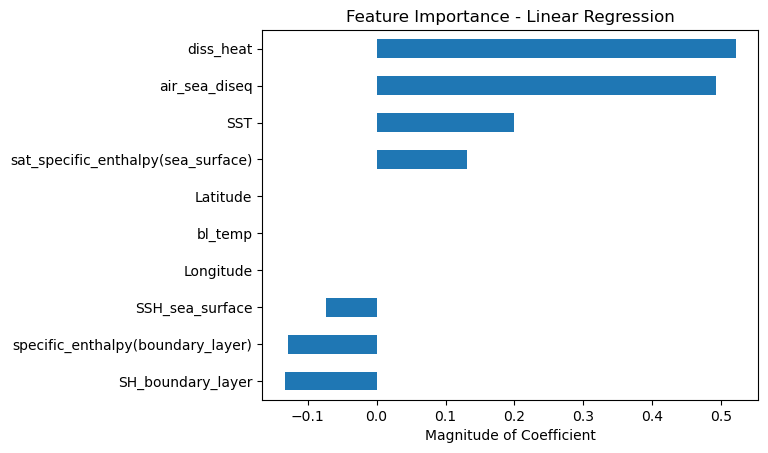

In [34]:
#Feature importance for linear regression
features_without_MPI = main_data[30].drop('MPI',axis=1)
feature_coefficients = pd.Series(linear_reg.coef_[0], index=features_without_MPI.columns)

# Plot feature importance
feature_coefficients.sort_values().plot(kind='barh')
plt.title('Feature Importance - Linear Regression')
plt.xlabel('Magnitude of Coefficient')
plt.show()

In [35]:
#Using a decision-tree regressor
#Using the make_pipeline method
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

#SCALE THE DATA - each of the features are at different ranges (ASD - 0 - 10000 J/kg, DH = 0 - 1)
#Scale the xdata
Xscaler = StandardScaler()
Xscaler.fit(x_train)
X_train_scaled = Xscaler.transform(x_train)

#Scale the ydata
Yscaler = StandardScaler()
Yscaler.fit(y_train)
Y_train_scaled = Yscaler.transform(y_train)

#FIT THE MODEL
# Initialize and train a linear regression model with ridge regularization, using make_pipeline
dec_tree_reg = DecisionTreeRegressor()

#fit the model
dec_tree_reg.fit(X_train_scaled,Y_train_scaled)

#EVAULATE THE MODEL
#scale the testing data using the scaler that we already fitted with the training data
X_test_scaled = Xscaler.transform(x_test)

#get the model prediction on the test data
Y_pred_scaled = dec_tree_reg.predict(X_test_scaled)

#the prediction is currently in the scaled units, let's recover the original units:
y_pred = Yscaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)) #sometimes you need the .reshape here for some reason, depending on the model

#Evaluate the model 
print("RMSE for decision tree regression:", np.sqrt(np.mean((y_test-y_pred)**2)))

RMSE for decision tree regression: 0.10571665795791771


In [36]:
#Visualize the results
ypred = np.reshape(y_pred,(10,32,64))
ytest = np.reshape(y_test,(10,32,64))

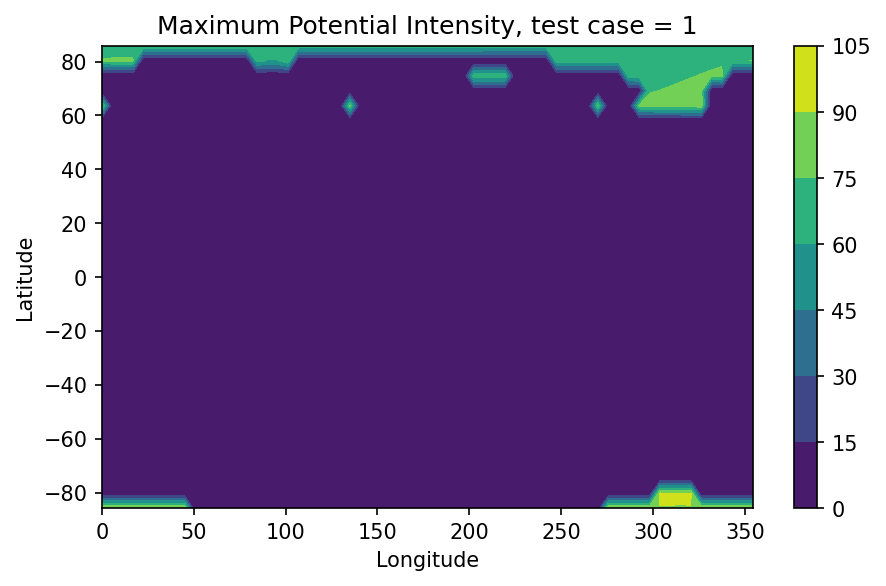

In [37]:
#Visualize the results, test_case = 1
fig = plt.figure(figsize=(7,4),dpi=150)
plt.title("Maximum Potential Intensity, test case = 1")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.contourf(lon,lat,ytest[4])
plt.colorbar()

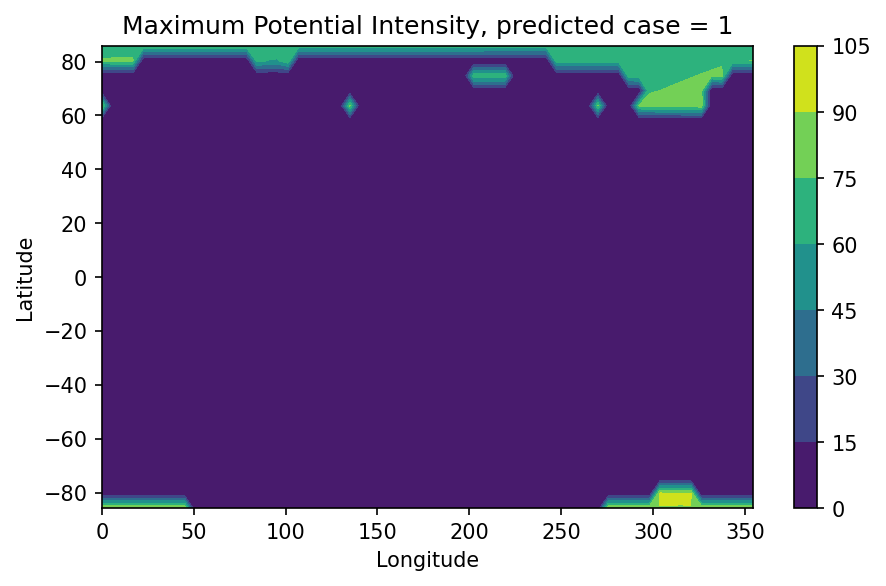

In [38]:
#Visualize the results, predicted_case = 1
fig = plt.figure(figsize=(7,4),dpi=150)
plt.title("Maximum Potential Intensity, predicted case = 1")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.contourf(lon,lat,ypred[4])
plt.colorbar()

Latitude: 2.5416346523697044e-08
Longitude: 1.3861048117646288e-08
air_sea_diseq: 0.021131216312187454
diss_heat: 0.9788680925361635
SSH_sea_surface: 2.634466737741556e-07
SH_boundary_layer: 7.368205120608621e-08
SST: 1.2585686235623555e-07
sat_specific_enthalpy(sea_surface): 1.1079007969029484e-07
specific_enthalpy(boundary_layer): 4.678526115785725e-08
bl_temp: 3.131332628867991e-08


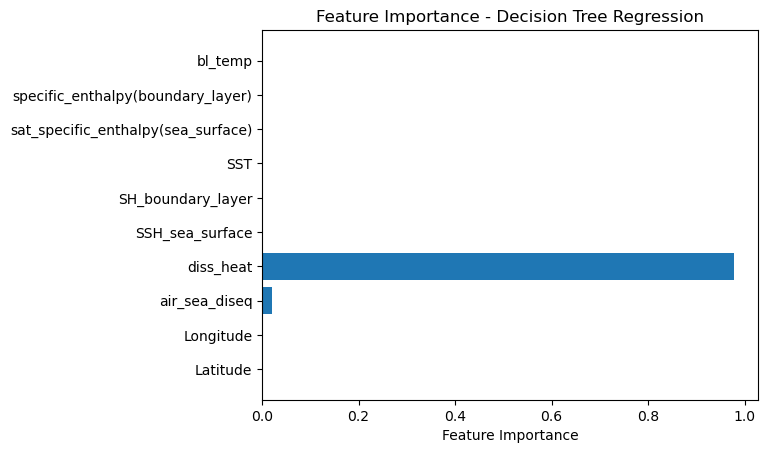

In [39]:
#Feature importance for decision tree regression
# Feature importance analysis
feature_importances = dec_tree_reg.feature_importances_
features_without_MPI = main_data[30].drop('MPI',axis=1)
feature_names = features_without_MPI.columns

# Print feature importances
for feature, importance in zip(feature_names, feature_importances):
    print(f'{feature}: {importance}')

# Plot feature importances
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Decision Tree Regression')
plt.savefig("FI_DTR.jpg")
plt.show()

In [40]:
#Using the random forest method
#Using the make_pipeline method
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

#SCALE THE DATA - each of the features are at different ranges (ASD - 0 - 10000 J/kg, DH = 0 - 1)
#Scale the xdata
Xscaler = StandardScaler()
Xscaler.fit(x_train)
X_train_scaled = Xscaler.transform(x_train)

#Scale the ydata
Yscaler = StandardScaler()
Yscaler.fit(y_train)
Y_train_scaled = Yscaler.transform(y_train)

#FIT THE MODEL
# Initialize and train a linear regression model with ridge regularization, using make_pipeline
ran_fore_reg = RandomForestRegressor()

#fit the model
ran_fore_reg.fit(X_train_scaled,Y_train_scaled)

#EVAULATE THE MODEL
#scale the testing data using the scaler that we already fitted with the training data
X_test_scaled = Xscaler.transform(x_test)

#get the model prediction on the test data
Y_pred_scaled = ran_fore_reg.predict(X_test_scaled)

#the prediction is currently in the scaled units, let's recover the original units:
y_pred = Yscaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)) #sometimes you need the .reshape here for some reason, depending on the model

#Evaluate the model 
print("RMSE for random forest regression:", np.sqrt(np.mean((y_test-y_pred)**2)))

C:\Users\David Moore\AppData\Local\Temp\ipykernel_24308\2632688568.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ran_fore_reg.fit(X_train_scaled,Y_train_scaled)


RMSE for random forest regression: 0.10351805271799117


In [41]:
ypred = np.reshape(y_pred,(10,32,64))
ytest = np.reshape(y_test,(10,32,64))

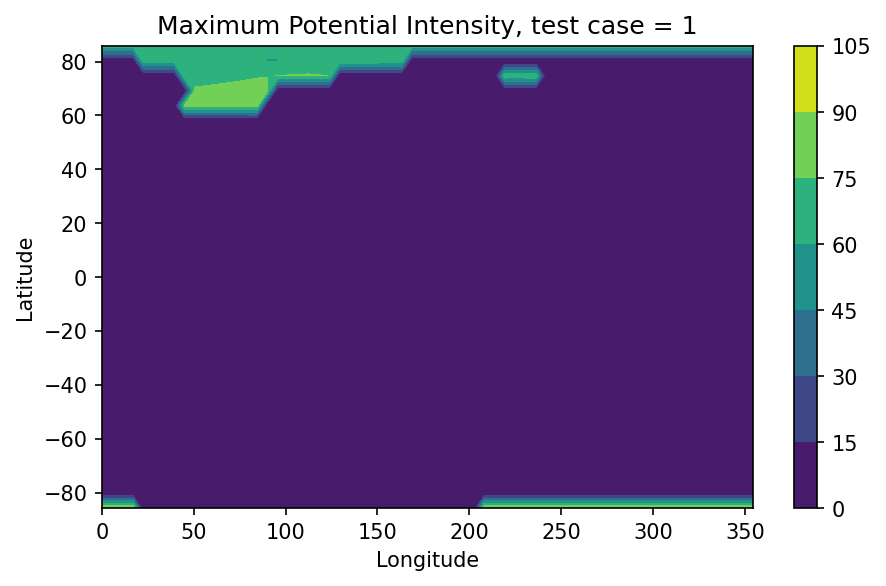

In [42]:
#Visualize results
fig = plt.figure(figsize=(7,4),dpi=150)
plt.title("Maximum Potential Intensity, test case = 1")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.contourf(lon,lat,ytest[0])
plt.colorbar()

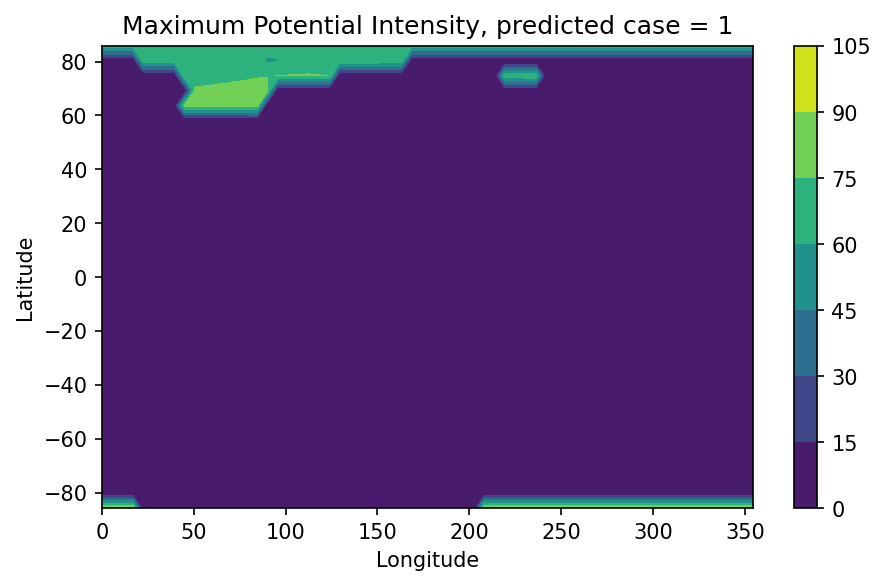

In [43]:
fig = plt.figure(figsize=(7,4),dpi=150)
plt.title("Maximum Potential Intensity, predicted case = 1")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.contourf(lon,lat,ypred[0])
plt.colorbar()

Latitude: 0.0004772539839794596
Longitude: 2.5756294283209053e-08
air_sea_diseq: 0.34380169823299667
diss_heat: 0.6549810049245081
SSH_sea_surface: 0.0001454191924922438
SH_boundary_layer: 7.738499702332996e-08
SST: 7.034152844820885e-05
sat_specific_enthalpy(sea_surface): 0.00012375202335518473
specific_enthalpy(boundary_layer): 0.00019256313168643612
bl_temp: 0.00020786384124233455


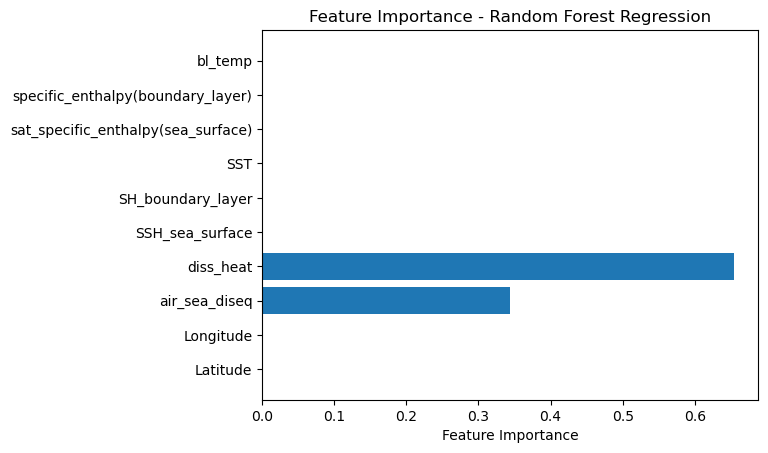

In [44]:
#Feature importance for random forest regression
# Feature importance analysis
feature_importances = ran_fore_reg.feature_importances_
features_without_MPI = main_data[30].drop('MPI',axis=1)
feature_names = features_without_MPI.columns

# Print feature importances
for feature, importance in zip(feature_names, feature_importances):
    print(f'{feature}: {importance}')

# Plot feature importances
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest Regression')
plt.savefig("FI_RFR.jpg")
plt.show()

### 6. Fine-tune your model
- This can be done rather quickly using sklearn's GridSearchCV function

In [45]:
#Find the best model configuration for this data, Using GridSearchCV
from sklearn.model_selection import GridSearchCV
rfr_model = RandomForestRegressor()
param = [{'n_estimators':[1,10,30,50,100],'max_depth':[None,10,20,30],'min_samples_split':[2,5,10],'min_samples_leaf':[1,2,4]}]
grid_search = GridSearchCV(rfr_model,param,cv=5,scoring='neg_root_mean_squared_error')

In [46]:
grid_search.fit(X_train_scaled,Y_train_scaled)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
#testing the best model on the test set
rf_model = RandomForestRegressor(max_depth=20,n_estimators=100,min_samples_leaf=1,min_samples_split=2)

#fit the model
rf_model.fit(X_train_scaled,Y_train_scaled)

#EVAULATE THE MODEL
#scale the testing data using the scaler that we already fitted with the training data
X_test_scaled = Xscaler.transform(x_test)

#get the model prediction on the test data
Y_pred_scaled = rf_model.predict(X_test_scaled)

#the prediction is currently in the scaled units, let's recover the original units:
y_pred = Yscaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)) #sometimes you need the .reshape here for some reason, depending on the model

ypred = np.reshape(y_pred,(10,32,64))
ytest = np.reshape(y_test,(10,32,64))

#Evaluate the model 
print("RMSE for random forest regression:", np.sqrt(np.mean((ytest-ypred)**2)))

In [ ]:
#Check the shape
print(np.shape(y_test))
print(np.shape(y_pred))

In [56]:
#Reshape
ypred = np.reshape(y_pred,(10,32,64))
ytest = np.reshape(y_test,(10,32,64))

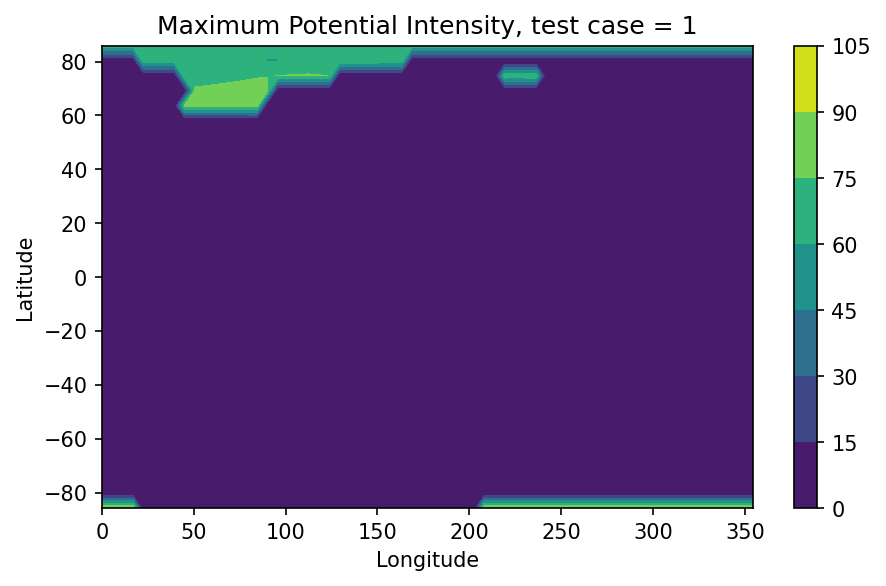

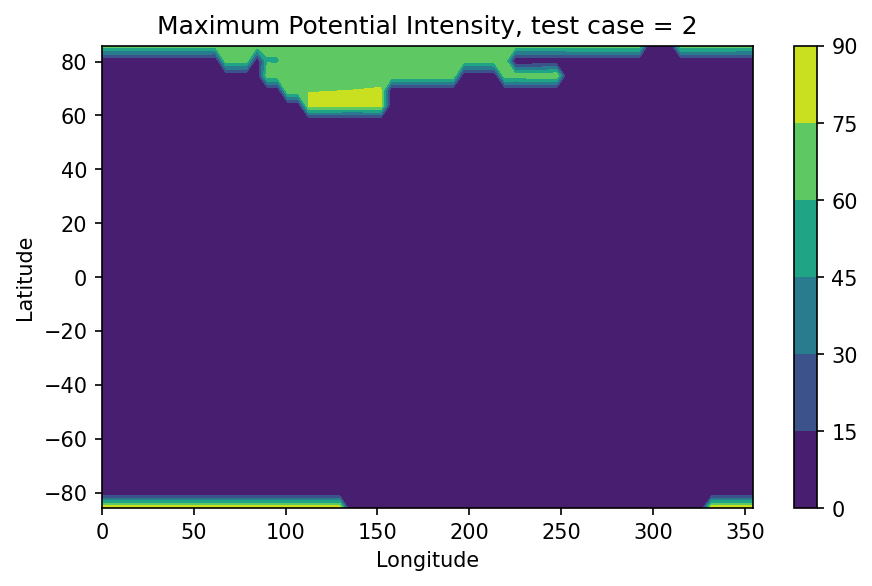

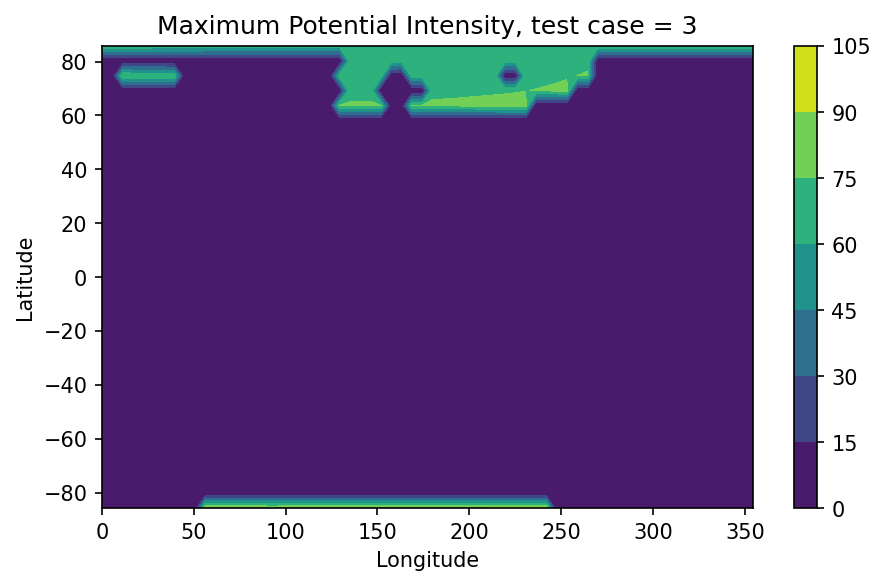

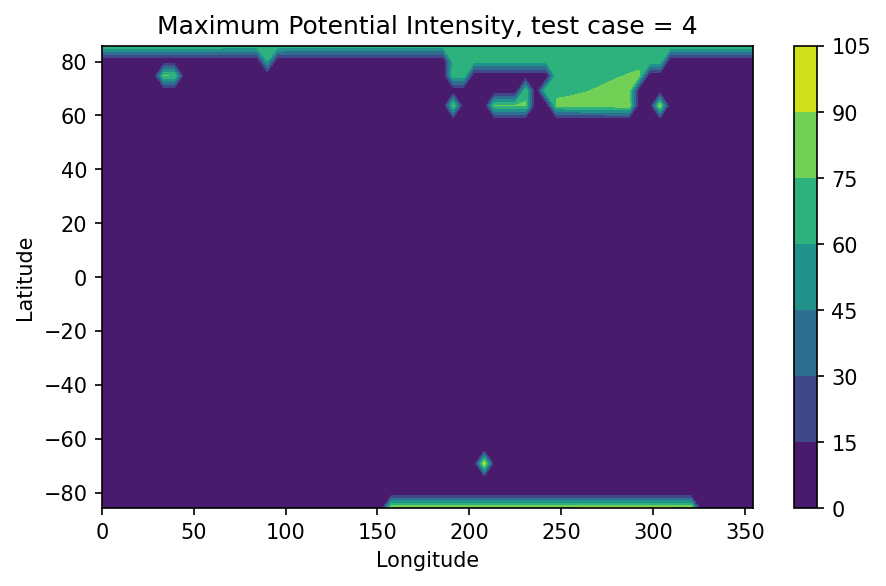

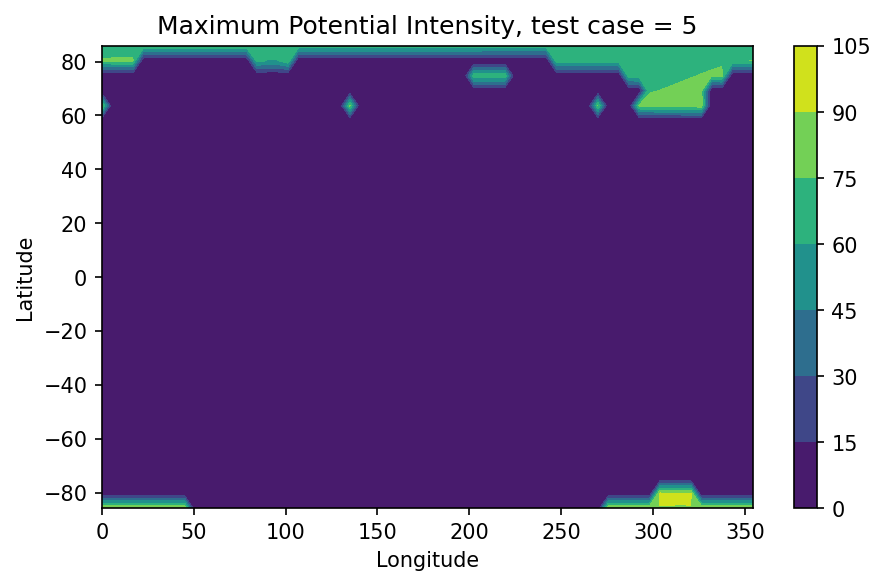

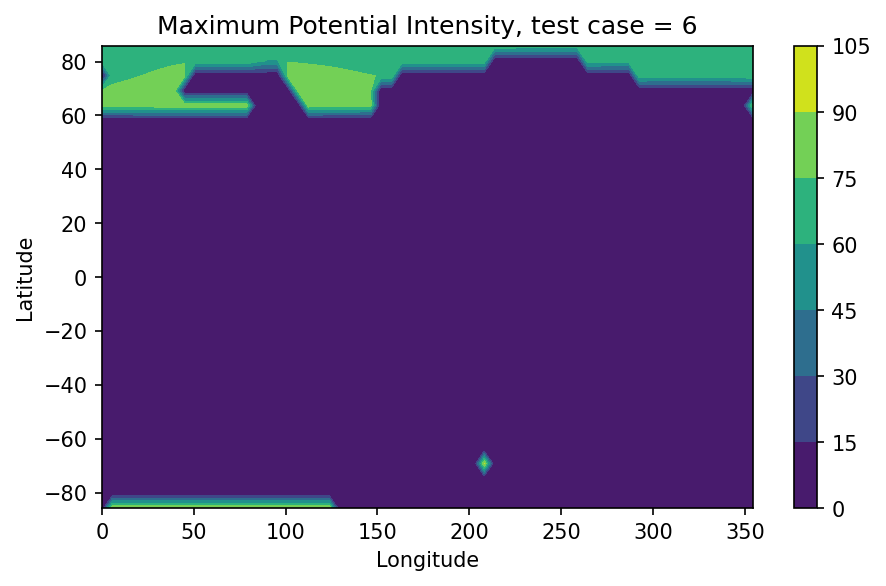

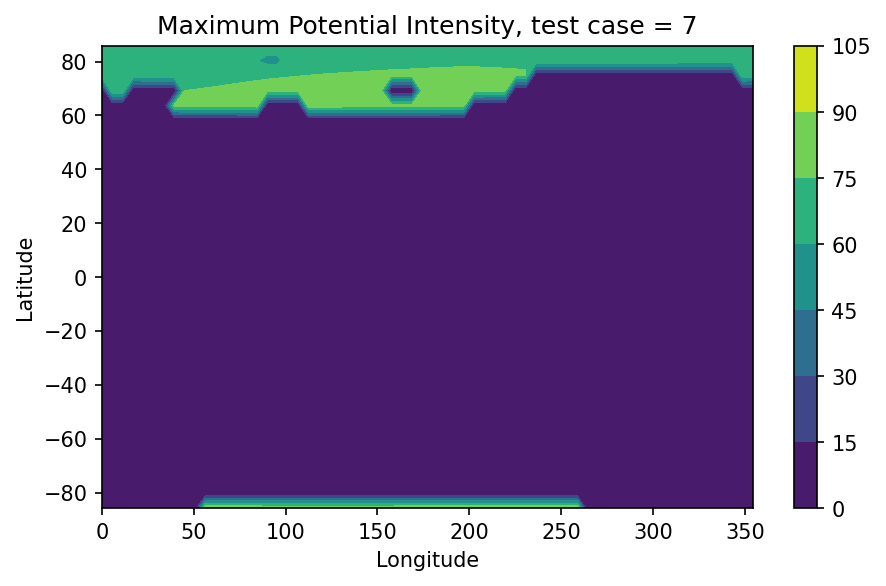

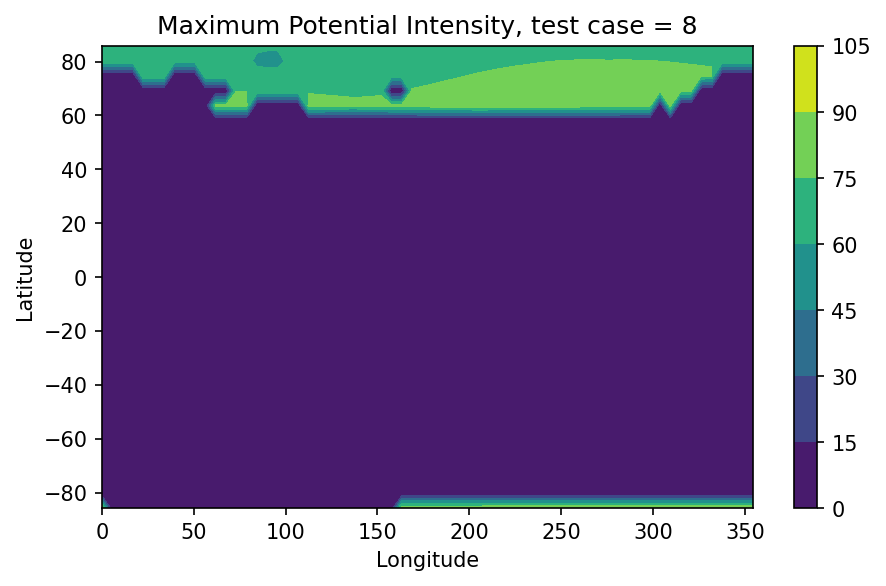

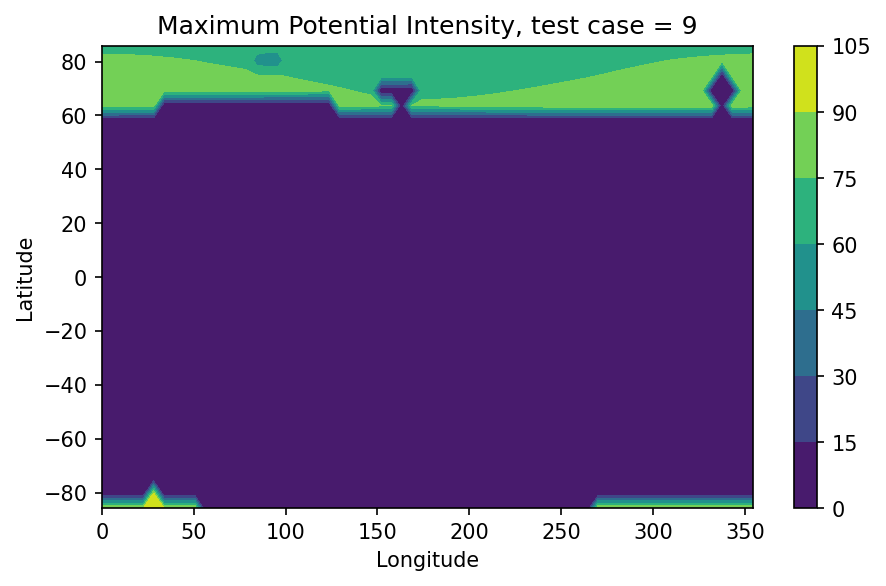

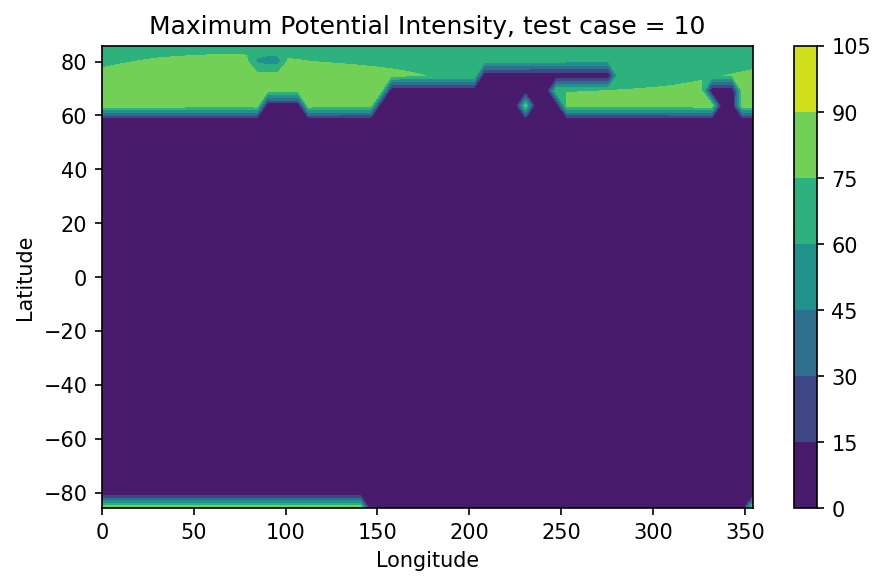

In [37]:
#Visualize the test cases
for x in range(len(ytest)):
    #Plotting
    #Visualize results
    fig = plt.figure(figsize=(7,4),dpi=150)
    plt.title("Maximum Potential Intensity, test case = "+str(x+1))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.contourf(lon,lat,ytest[x])
    plt.colorbar()
    plt.savefig('mpi_test'+str(x)+'.jpg')

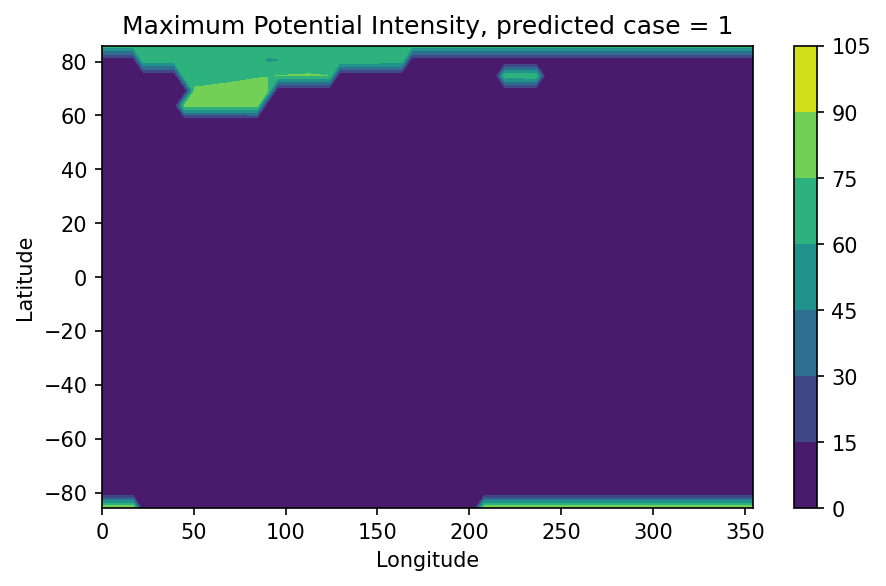

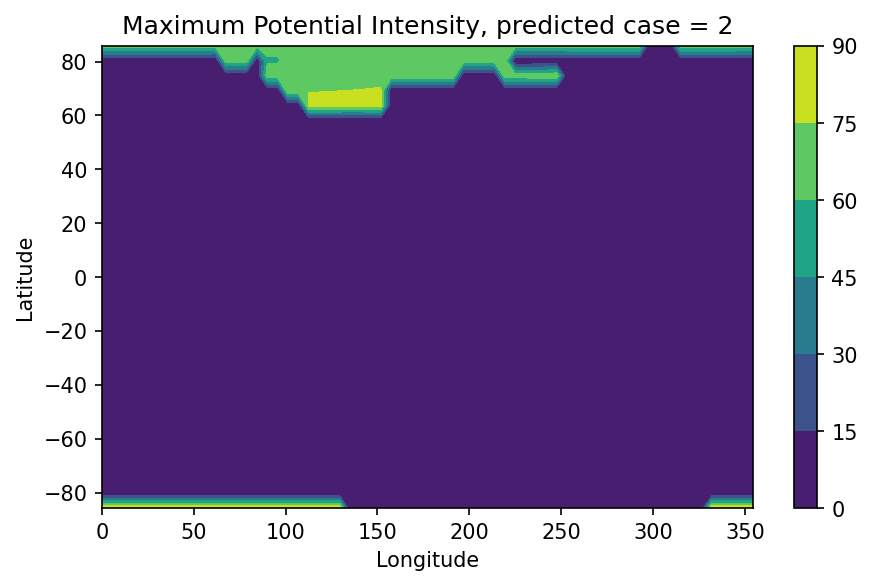

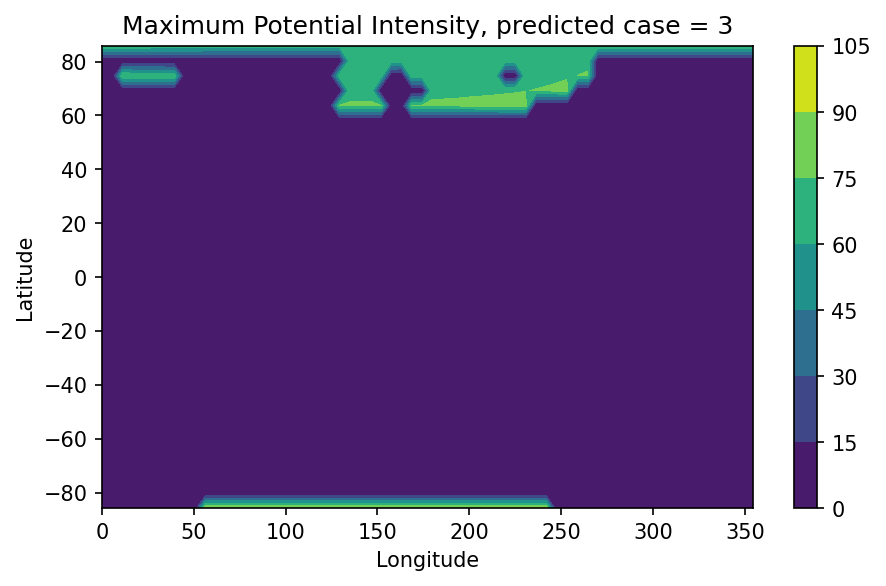

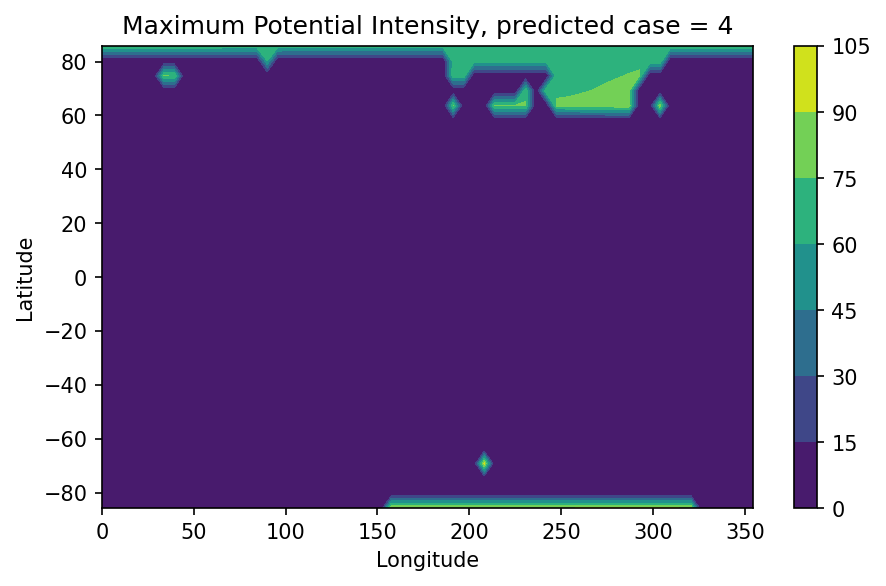

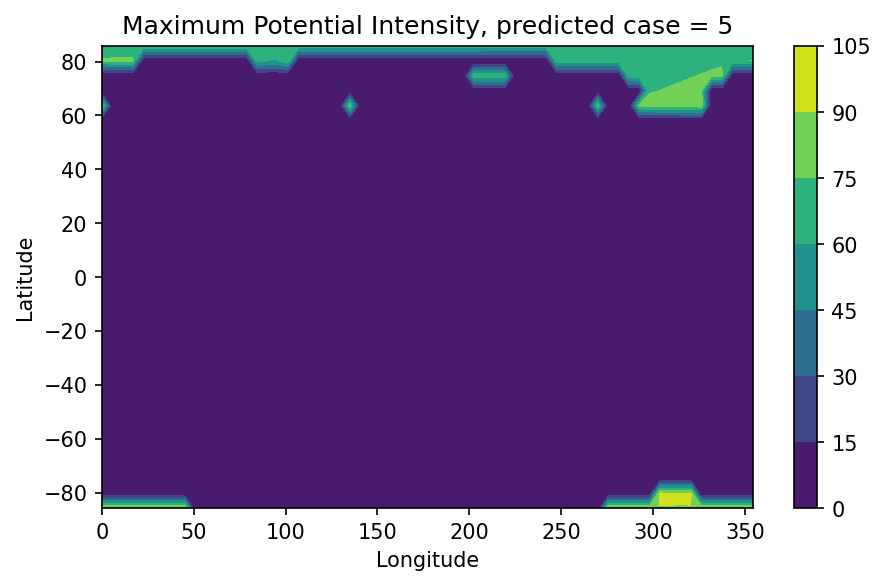

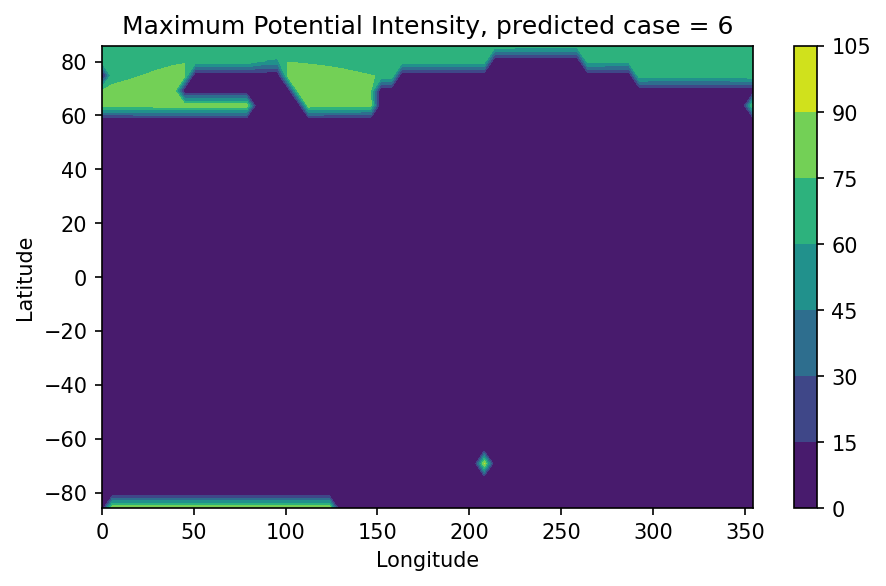

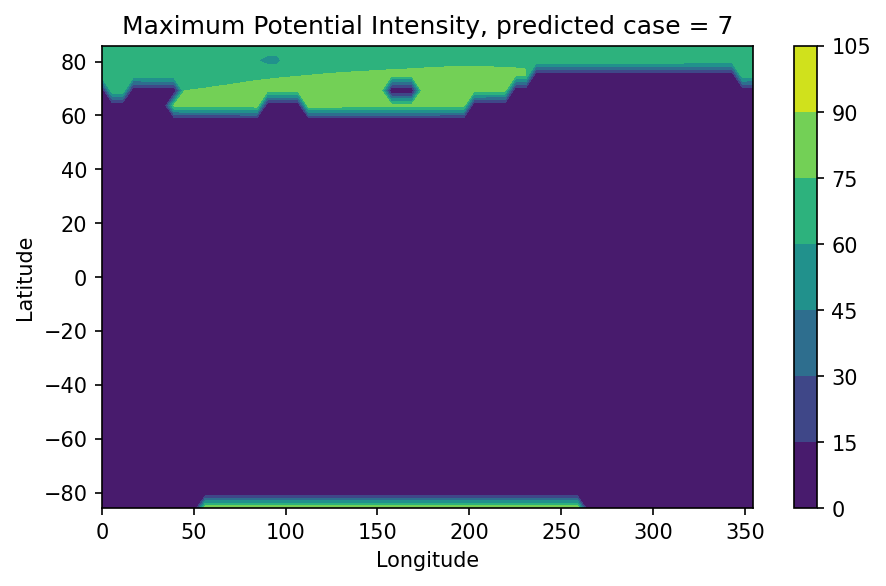

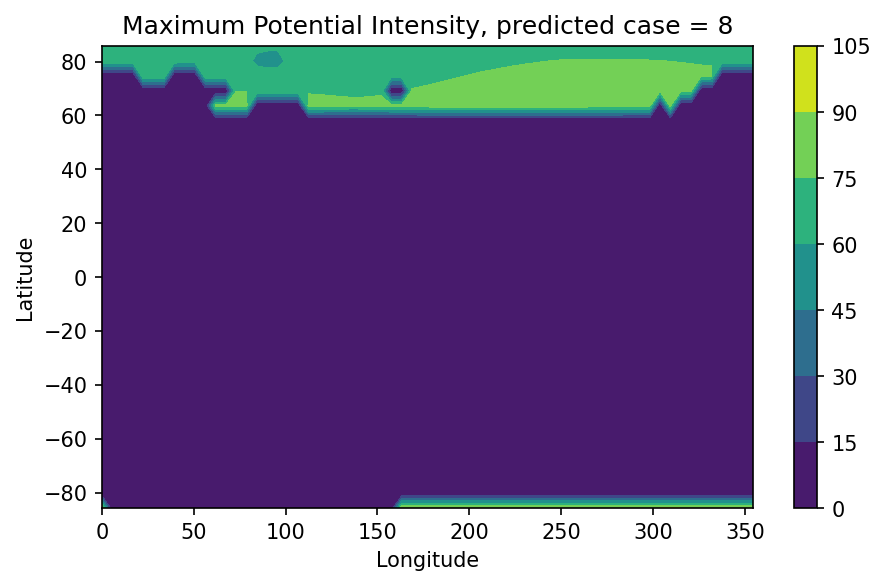

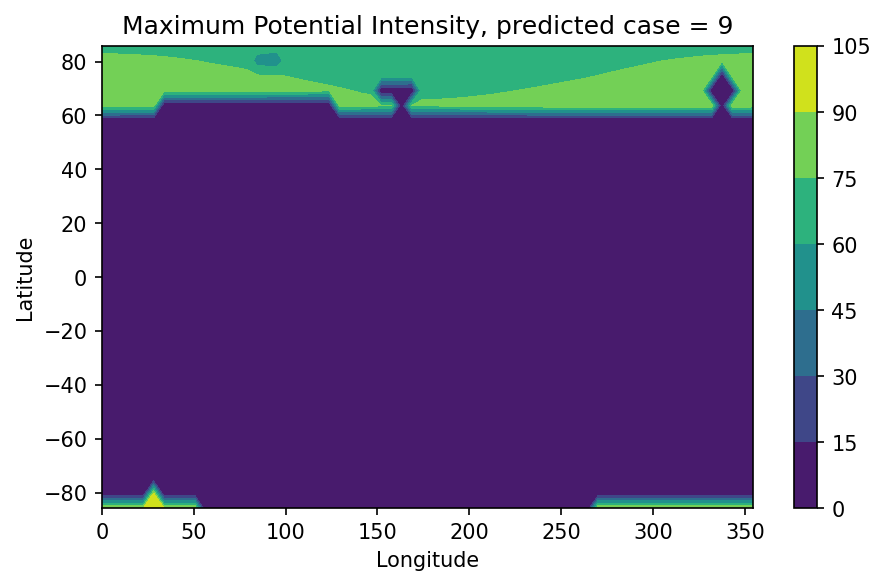

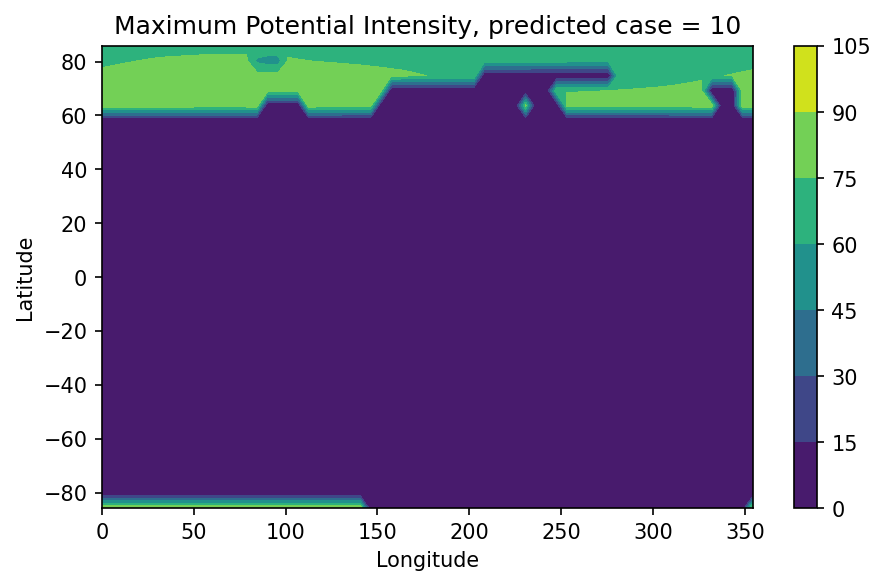

In [38]:
#Visualize the predicted cases
for x in range(len(ytest)):
    #Plotting
    #Visualize results
    fig = plt.figure(figsize=(7,4),dpi=150)
    plt.title("Maximum Potential Intensity, predicted case = "+str(x+1))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.contourf(lon,lat,ypred[x])
    plt.colorbar()
    plt.savefig('mpi_pred'+str(x)+'.jpg')

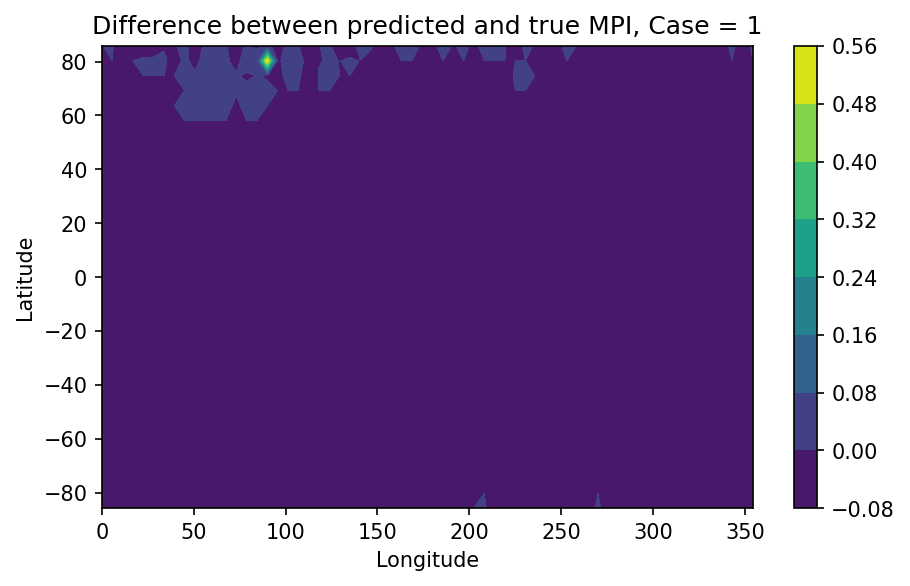

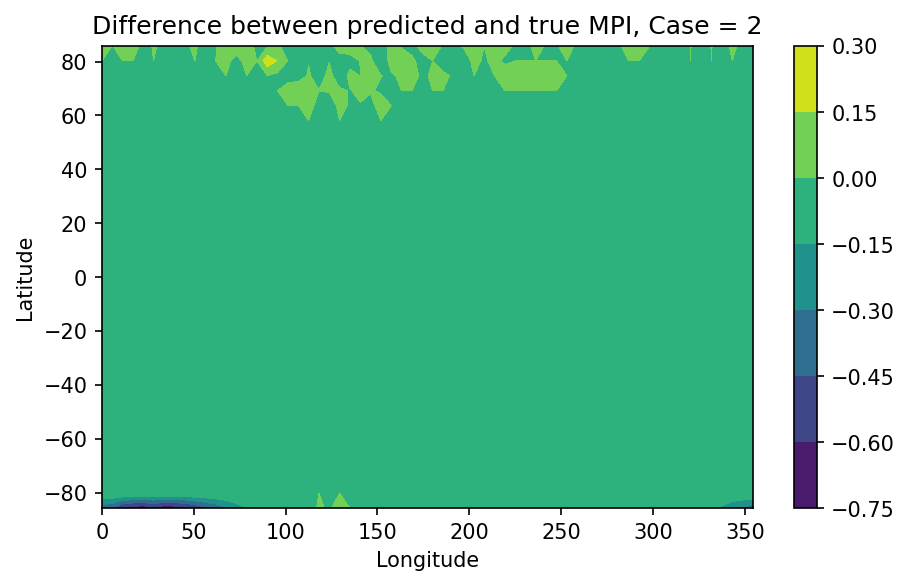

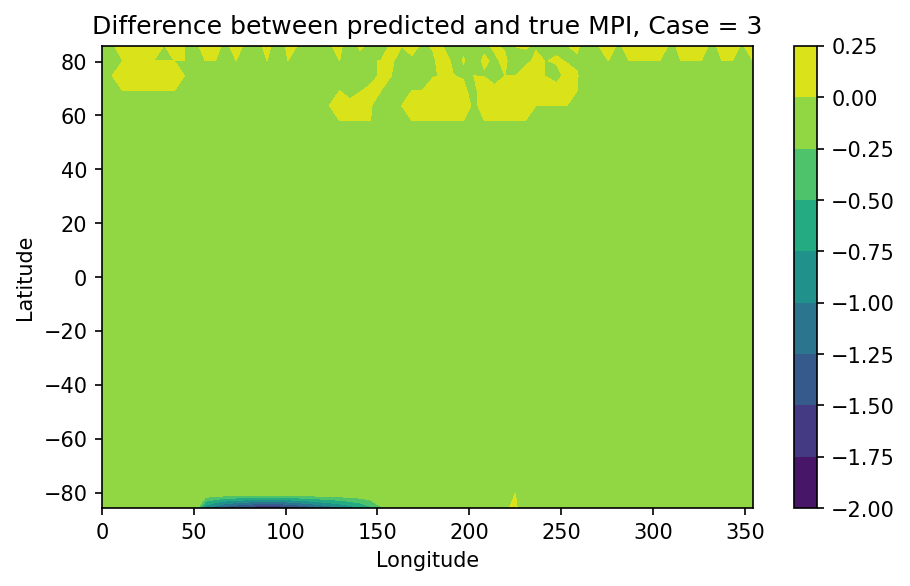

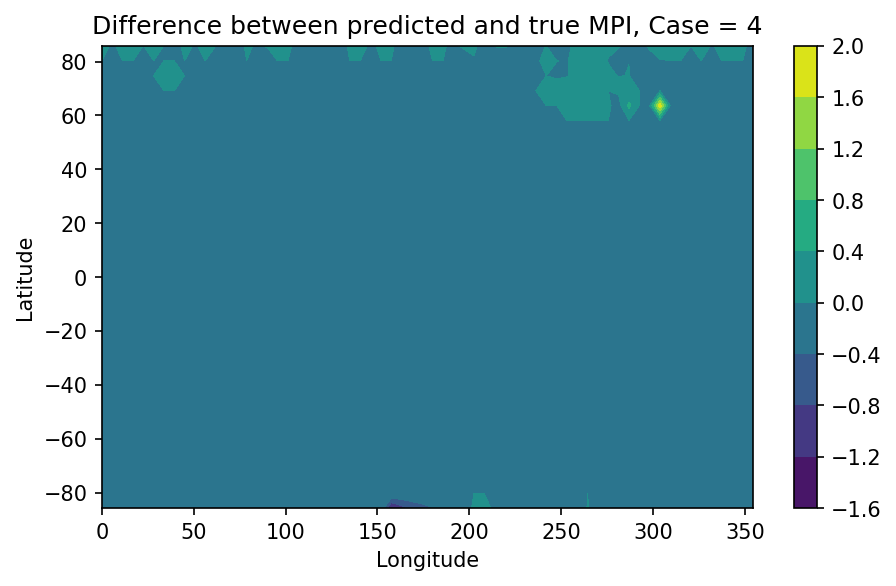

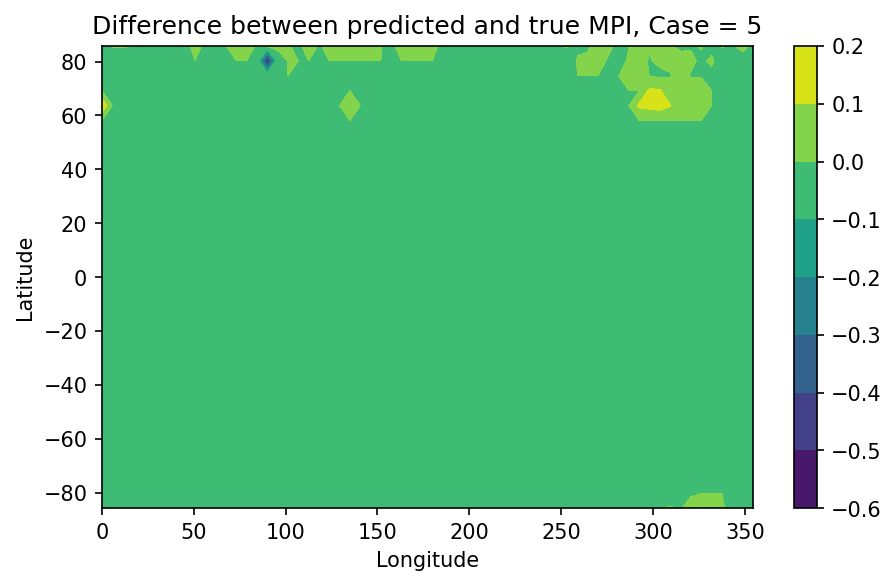

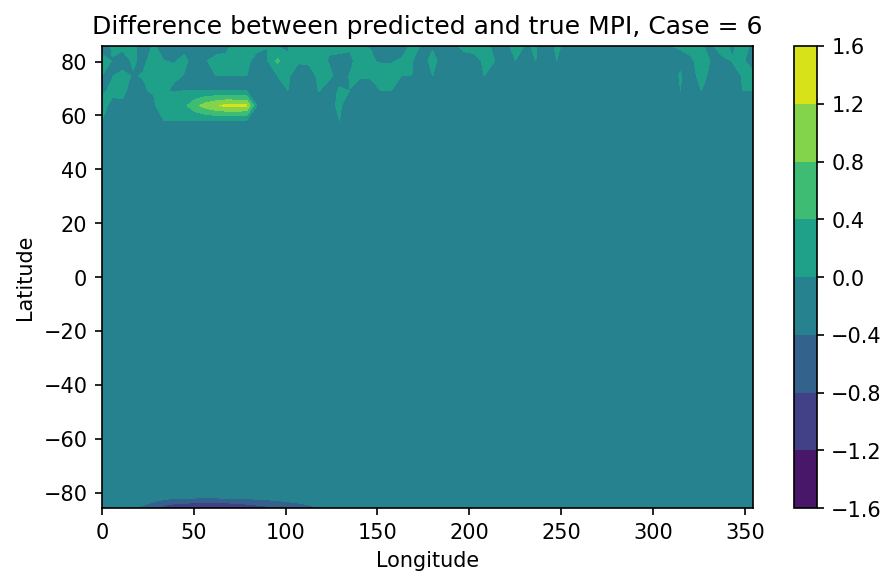

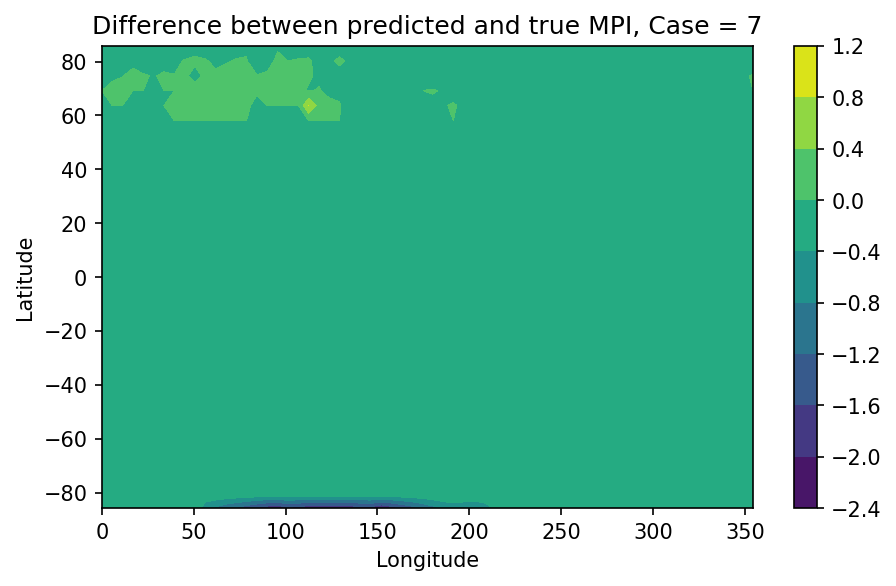

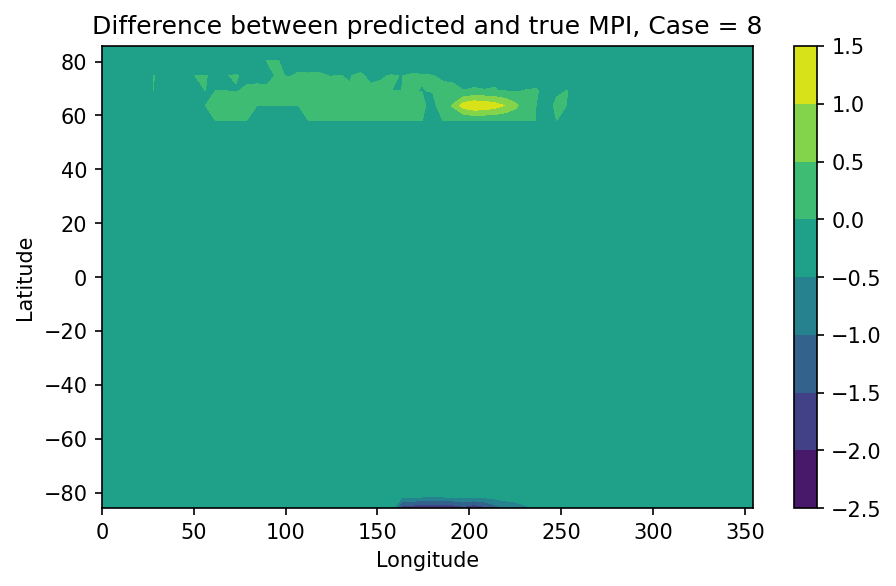

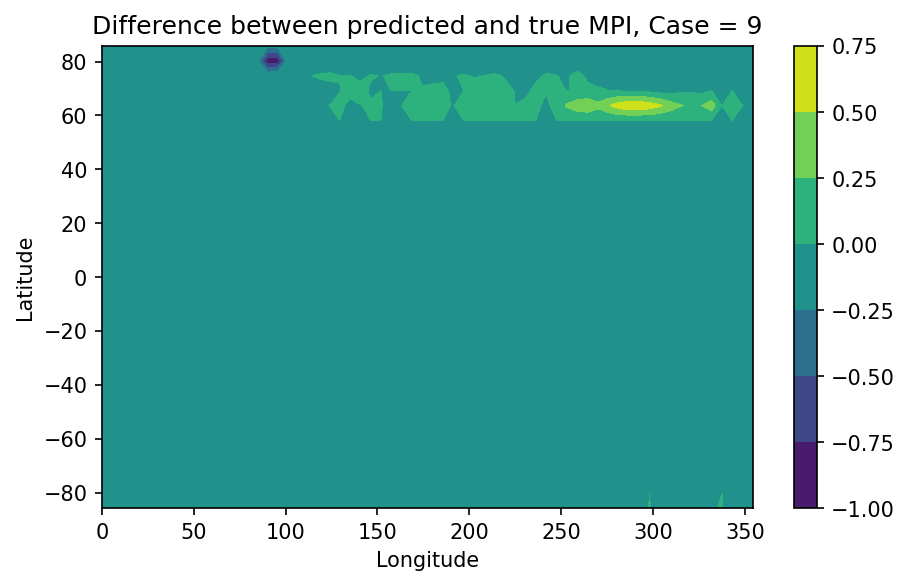

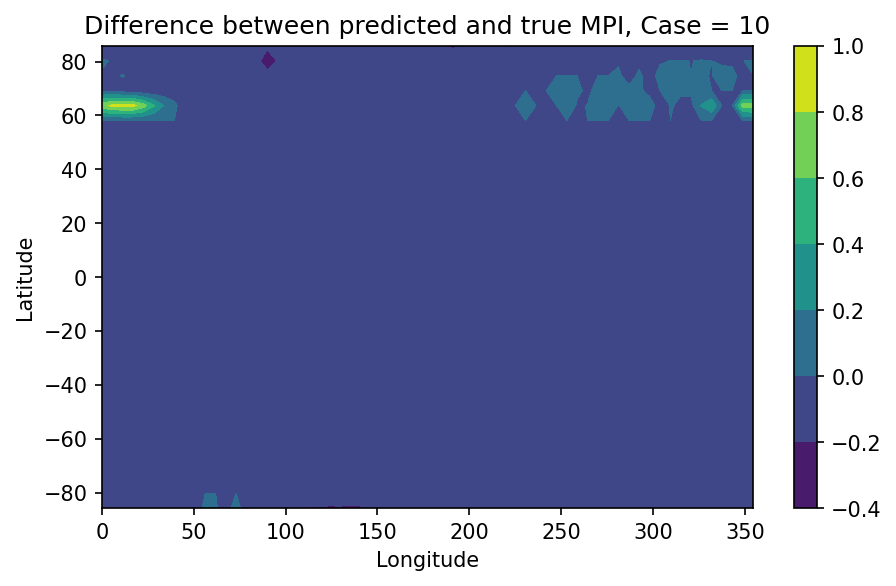

In [39]:
#Difference between predicted and true values
for x in range(len(ytest)):
    #Plotting
    #Visualize results
    fig = plt.figure(figsize=(7,4),dpi=150)
    plt.title("Difference between predicted and true MPI, Case = "+str(x+1))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    diff = ytest[x] - ypred[x]
    plt.contourf(lon,lat,diff)
    plt.colorbar()
    plt.savefig('mpi_diff'+str(x)+'.jpg')

Latitude: 0.0004537443653203014
Longitude: 2.6208282144032526e-08
air_sea_diseq: 0.37313919174112153
diss_heat: 0.6256841357267305
SSH_sea_surface: 0.00012029630092543105
SH_boundary_layer: 8.112556475349829e-08
SST: 0.00016496629983390906
sat_specific_enthalpy(sea_surface): 0.0001295575248003616
specific_enthalpy(boundary_layer): 0.0001972817497999873
bl_temp: 0.00011071895762112665


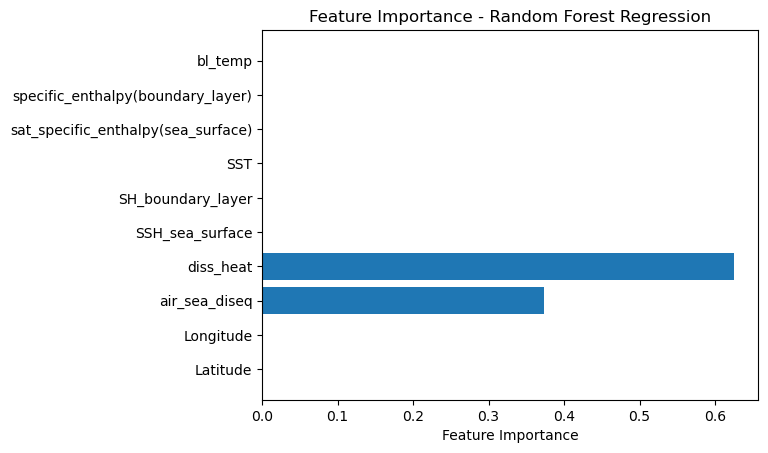

In [73]:
#feature importance between variables
# Feature importance analysis
feature_importances = rf_model.feature_importances_
features_without_MPI = main_data[30].drop('MPI',axis=1)
feature_names = features_without_MPI.columns

# Print feature importances
for feature, importance in zip(feature_names, feature_importances):
    print(f'{feature}: {importance}')

# Plot feature importances
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest Regression')
plt.savefig("FI_RFR_final.jpg")
plt.show()